In [57]:
# Import denpendecies
import requests
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Extracting data from Postgres using APIs

In [2]:
# Define a list of table names and their corresponding API endpoints
tables = {
            
        "Bureau" : 'http://127.0.0.1:5000/bureau',
        "Bureau_balance" : 'http://127.0.0.1:5000/bureau_balance',
        "Credit_card_balance" : 'http://127.0.0.1:5000/credit_card_balance',
        "Installments_payments" : 'http://127.0.0.1:5000/installments_payments',
        "POS_CASH_balance" : 'http://127.0.0.1:5000/pOS_CASH_balance',
        "Previous_application" : 'http://127.0.0.1:5000/previous_application',
        "Application_train" : 'http://127.0.0.1:5000/application_train'
}

# Dictionary to store DataFrames for each table
dataframes = {}

# Make API requests to get data from each table
for table_name, endpoint in tables.items():
    response = requests.get(endpoint)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Convert API response to a DataFrame and store it in the dictionary
        dataframes[table_name] = pd.DataFrame(response.json())
        print(f"Data for {table_name} fetched successfully.")
    else:
        print(f"Error: Unable to fetch data from {table_name}. Status code: {response.status_code}")

Data for Bureau fetched successfully.
Data for Bureau_balance fetched successfully.
Data for Credit_card_balance fetched successfully.
Data for Installments_payments fetched successfully.
Data for POS_CASH_balance fetched successfully.
Data for Previous_application fetched successfully.
Data for Application_train fetched successfully.


## Combining DataFrames

In [26]:
# Merge tables based on specified keys
merged_table = dataframes["Application_train"]

# Merge POS_CASH_balance, Installments_payments, Credit_card_balance based on SK_ID_PREV
for table_name in ["POS_CASH_balance", "Installments_payments", "Credit_card_balance", "Previous_application"]:
    if table_name in dataframes:
        # Specify suffixes to avoid duplicate column names
        merged_table = pd.merge(merged_table, dataframes[table_name], on='SK_ID_CURR', how='left', suffixes=('', f'_{table_name}'))

# Merge Bureau and Bureau_balance based on SK_ID_BUREAU
if "Bureau" in dataframes and "Bureau_balance" in dataframes:
    bureau_merged = pd.merge(dataframes["Bureau"], dataframes["Bureau_balance"], on='SK_ID_BUREAU', how='left', suffixes=('_bureau', '_bureau_balance'))
    merged_table = pd.merge(merged_table, bureau_merged, on='SK_ID_CURR', how='left')

# Display the final merged table with unique columns
unique_columns = merged_table.columns.unique()
final_table = merged_table[unique_columns]

# Display the final table
print(final_table.head())

   AMT_ANNUITY_x  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
0        21519.0    663093.0         553500.0          144000.0   
1        22171.5    835605.0         697500.0          112500.0   
2        43443.0   1575000.0        1575000.0          270000.0   
3        20979.0    450000.0         450000.0          157500.0   
4        43375.5    547344.0         472500.0          270000.0   

   AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         0.0   
4                        0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        1.0   
2                        0.0                        0.0   


## Cleaning & Encoding categorical variables

In [27]:
# Drop duplicate values
data_df = final_table.drop_duplicates()

In [28]:
# Fill na with (0)
data_df=data_df.fillna(0)

In [30]:
# Changing CODE_GENDER to 0 and 1 to match model
data_df['CODE_GENDER'] = data_df['CODE_GENDER'].replace({'F': 0, 'M': 1})

In [31]:
# Changing FLAG_OWN_REALTY AND FLAG_OWN_CAR to 0 and 1 to match model
data_df[['FLAG_OWN_REALTY', 'FLAG_OWN_CAR']] = data_df[['FLAG_OWN_REALTY', 'FLAG_OWN_CAR']].replace({'Y': 1, 'N': 0}).astype(int)

## Assigning Values to X and y

In [32]:
# Selecting X features
X = data_df.drop(columns=['TARGET'], axis=1)

In [33]:
# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X).astype(int)

In [34]:
# select Target variable
y = data_df['TARGET'].values

## Machine learning model: Randon Forest Classifier

In [35]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate a StandardScaler instance

scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

# Get probability outputs for the test set
probabilities = model.predict_proba(X_test_scaled)

# Extract the probability of the positive class (class 1)
positive_class_probabilities = probabilities[:, 1]

# Define a threshold to make binary predictions
threshold = 0.5
binary_predictions = (positive_class_probabilities > threshold).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)

# Print the confusion matrix and accuracy
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)

Confusion Matrix:
[[28444     0]
 [ 1625   887]]

Accuracy: 0.9475061377438946


In [12]:
report = classification_report(y_test, binary_predictions)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     28444
           1       1.00      0.35      0.52      2512

    accuracy                           0.95     30956
   macro avg       0.97      0.68      0.75     30956
weighted avg       0.95      0.95      0.94     30956



## Assigning risk levels

In [36]:
# Extract the probability of the positive class (class 1)
positive_class_probabilities = probabilities[:, 1]

# Define custom thresholds for each class
thresholds = [0.2, 0.4, 0.6, 0.8]

# Classify into 5 classes based on custom thresholds
risk_levels = pd.cut(positive_class_probabilities, bins=[-float('inf')] + thresholds + [float('inf')],
                     labels=['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk'], include_lowest=True)

# Create a DataFrame with 'SK_ID_CURR', probability, and risk level
result_df = pd.DataFrame({'SK_ID_CURR': X_test['SK_ID_CURR'],'Probability': positive_class_probabilities, 'Risk Level': risk_levels})
result_df.sort_values(by='SK_ID_CURR', ascending=True, inplace=True)
result_df = result_df.drop_duplicates()
result_df = result_df.reset_index(drop=True)
# Print the result DataFrame
print(result_df)

       SK_ID_CURR  Probability     Risk Level
0          331614         0.16  Very Low Risk
1          331619         0.05  Very Low Risk
2          331625         0.01  Very Low Risk
3          331625         0.00  Very Low Risk
4          331633         0.21       Low Risk
...           ...          ...            ...
28125      447283         0.16  Very Low Risk
28126      447292         0.02  Very Low Risk
28127      447295         0.11  Very Low Risk
28128      447299         0.10  Very Low Risk
28129      447306         0.05  Very Low Risk

[28130 rows x 3 columns]


## Top contributing features

In [37]:
# Random Forests in sklearn will automatically calculate feature importance
importances = model.feature_importances_
# We can sort the features by their importance
importances_sorted = sorted(zip(model.feature_importances_, X.columns), reverse=True)
importances_sorted = importances_sorted[:25]
sorted_df = pd.DataFrame(importances_sorted)
sorted_df[1]

0                          DAYS_BIRTH
1                   DAYS_REGISTRATION
2                     DAYS_ID_PUBLISH
3                          SK_ID_CURR
4              DAYS_LAST_PHONE_CHANGE
5                       AMT_ANNUITY_x
6                          AMT_CREDIT
7                       DAYS_EMPLOYED
8                    AMT_INCOME_TOTAL
9                     AMT_GOODS_PRICE
10            HOUR_APPR_PROCESS_START
11         AMT_REQ_CREDIT_BUREAU_YEAR
12                        OWN_CAR_AGE
13           OBS_60_CNT_SOCIAL_CIRCLE
14           OBS_30_CNT_SOCIAL_CIRCLE
15                    CNT_FAM_MEMBERS
16                         SK_ID_PREV
17                       SK_ID_BUREAU
18                   MONTHS_BALANCE_x
19     SK_ID_PREV_Credit_card_balance
20              CNT_INSTALMENT_FUTURE
21                     CNT_INSTALMENT
22                       CNT_CHILDREN
23          AMT_REQ_CREDIT_BUREAU_QRT
24    SK_ID_PREV_Previous_application
Name: 1, dtype: object

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

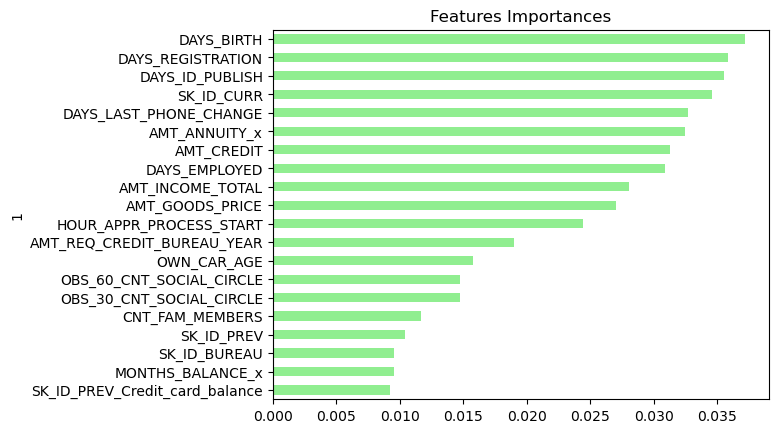

In [16]:
sorted_df.set_index(sorted_df[1], inplace=True)
sorted_df.drop(columns=1, inplace=True)
sorted_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = sorted_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

## Selecting top contributing features

In [62]:
X  = data_df[[
            "SK_ID_CURR", # ID of loan in our sample
            "DAYS_BIRTH", #Client's age in days at the time of application
            "DAYS_REGISTRATION", #How many days before the application did client change his registration
            "DAYS_ID_PUBLISH", #How many days before the application did client change the identity document with which he applied for the loan
            "DAYS_LAST_PHONE_CHANGE", #How many days before application did client change phone
            "AMT_ANNUITY_x", #Loan annuity
            "AMT_CREDIT", #Credit amount of the loan
            "DAYS_EMPLOYED", # How many days before the application the person started current employment
            "AMT_INCOME_TOTAL", #Income of the client
            "AMT_GOODS_PRICE",#For consumer loans it is the price of the goods for which the loan is given
            "OWN_CAR_AGE", #Age of client's car
            "CNT_FAM_MEMBERS",# No. of family dependent family members
            "CNT_INSTALMENT_FUTURE",# Installments left to pay on the previous credit
            "CNT_INSTALMENT", #Term of previous credit (can change over time)
            "CNT_CHILDREN", #Number of childeren applicant has
            "AMT_REQ_CREDIT_BUREAU_QRT" #Number of enquiries to Credit Bureau about the client 3 month before application (excluding one month before application)
]]

In [63]:
# Fillna (0) in the selective features
X_features = X.fillna(0)

In [64]:
# Selective target variable
y_features = data_df['TARGET']

## Machine learning model: Random Forest Classifier

In [65]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size=0.2, random_state=42)

# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

# Initialize the RandomForestClassifier
model_features = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model_features.fit(X_train_scaled, y_train)

# Get probability outputs for the test set
probabilities_features = model_features.predict_proba(X_test_scaled)

# Extract the probability of the positive class (class 1)
positive_class_probabilities_features = probabilities_features[:, 1]

# Define a threshold to make binary predictions
threshold = 0.5
binary_predictions_features = (positive_class_probabilities_features > threshold).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_features)

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions_features)

# Print the confusion matrix and accuracy
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)

Confusion Matrix:
[[28443     1]
 [ 1439  1073]]

Accuracy: 0.953482362062282


In [54]:
report = classification_report(y_test, binary_predictions_features)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     28444
           1       1.00      0.43      0.60      2512

    accuracy                           0.95     30956
   macro avg       0.98      0.71      0.79     30956
weighted avg       0.96      0.95      0.94     30956



In [55]:
# Extract the probability of the positive class (class 1)
positive_class_probabilities_features = probabilities_features[:, 1]

# Define custom thresholds for each class
thresholds = [0.2, 0.4, 0.6, 0.8]

# Classify into 5 classes based on custom thresholds
risk_levels_features = pd.cut(positive_class_probabilities_features, bins=[-float('inf')] + thresholds + [float('inf')],
                     labels=['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk'], include_lowest=True)

# Create a DataFrame with 'SK_ID_CURR', probability, and risk level
result_df_features = pd.DataFrame({'SK_ID_CURR': X_test['SK_ID_CURR'],'Probability': positive_class_probabilities_features, 'Risk Level': risk_levels_features})
result_df_features.sort_values(by='SK_ID_CURR', ascending=True, inplace=True)
result_df_features = result_df_features.drop_duplicates()
result_df_features = result_df_features.reset_index(drop=True)
# Print the result DataFrame
print(result_df_features)

       SK_ID_CURR  Probability     Risk Level
0          331614         0.16  Very Low Risk
1          331619         0.13  Very Low Risk
2          331625         0.00  Very Low Risk
3          331633         0.08  Very Low Risk
4          331634         0.09  Very Low Risk
...           ...          ...            ...
25729      447283         0.06  Very Low Risk
25730      447292         0.03  Very Low Risk
25731      447295         0.20  Very Low Risk
25732      447299         0.08  Very Low Risk
25733      447306         0.04  Very Low Risk

[25734 rows x 3 columns]


In [56]:
import joblib
joblib.dump(model_features, 'model_probability1.joblib')

['model_probability1.joblib']

In [ ]:
# Target variable for classification
y = data_df["TARGET"]

# Target variable for regression
y2 = data_df["AMT_CREDIT"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, y2_train, y2_test = train_test_split(X, y, y2, test_size=0.2, random_state=42)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict probabilities for the classification
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y2_train)

# Predict credit amounts for regression
y2_pred = rf_regressor.predict(X_test)

# Create a joint DataFrame with predictions
predictions_df = pd.DataFrame({
    "Classification_Probability": y_pred_proba,
    "Regression_Predicted_Amount": y2_pred,
    "True_Classification_Label": y_test,
    "True_Regression_Amount": y2_test
})


In [61]:
# predictions_df contains both classification probabilities and regression predictions
predictions_df.head()

,Classification_Probability,Regression_Predicted_Amount,True_Classification_Label,True_Regression_Amount
48569,0.15,531706.50,0,531706.5
99085,0.10,270000.00,0,270000.0
73357,0.03,1006920.00,0,1006920.0
43267,0.17,312768.00,0,312768.0
64494,0.05,121549.14,0,121500.0


In [60]:
# Exporting trained models in joblib for applicanting testing
import joblib
joblib.dump(rf_classifier, 'model_probability_feature.joblib')
joblib.dump(rf_regressor, 'model_predict_feature.joblib')

['model_predict_feature.joblib']